### 최종

In [1]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# pnu별 상가 면적
sql = '''
select sigungu_cd||bjdong_cd||case when plat_gb_cd = '1' then '2' else '1' end||bun||ji as pnu, avg(tot_area) as avg_area
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
   and base_ym = '202209'
 group by sigungu_cd||bjdong_cd||case when plat_gb_cd = '1' then '2' else '1' end||bun||ji
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['pnu','avg_area']
df_bld_rgst['emd_cd'] = df_bld_rgst['pnu'].str[:8] + '00'

# 거주 인구 (법정동 단위)
sql = '''
select cur_lgl_dong_cd||'00' as emd_cd , avg(case when pop_cnt = -1 then 1.5 else pop_cnt end) as pop_cnt
  from m1.kcb_stat_cm
 where bs_yr_mon = '202209'
 group by cur_lgl_dong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_kcb_stat_cm = pd.DataFrame(rows)
df_kcb_stat_cm.columns = ['emd_cd','pop_cnt']
df_kcb_stat_cm['pop_cnt'] = df_kcb_stat_cm['pop_cnt'].astype(float)


# 데이터 프레임 병합
df = pd.merge(df_bld_rgst, df_kcb_stat_cm, on='emd_cd', how='left')

# 인구가 0명, null인 지역 제외
df = df[~df['pop_cnt'].isnull()]

# 상가면적 / 거주인구
df['area_per_population'] = (df['avg_area'] / df['pop_cnt'])
df = df[~(df['area_per_population']==np.inf)].reset_index(drop=True)
df = df[['pnu','emd_cd','area_per_population']]
df['base_ym'] = datetime.today().strftime("%Y%m")


### 2. DB INSERT
import datetime

table = 'm2.datadam_area_per_population'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

2022-11-04 08:30:54.366911  :  0
2022-11-04 08:30:56.451473  :  10000
2022-11-04 08:30:57.767425  :  20000
2022-11-04 08:30:59.059404  :  30000
2022-11-04 08:31:00.497375  :  40000
2022-11-04 08:31:01.973040  :  50000
2022-11-04 08:31:05.431682  :  60000
2022-11-04 08:31:08.237302  :  70000
2022-11-04 08:31:09.676157  :  80000
2022-11-04 08:31:11.062837  :  90000
2022-11-04 08:31:12.473266  :  100000
2022-11-04 08:31:13.854493  :  110000
2022-11-04 08:31:17.574941  :  120000
2022-11-04 08:31:19.070730  :  130000
2022-11-04 08:31:20.726514  :  140000
2022-11-04 08:31:24.580577  :  150000
2022-11-04 08:31:25.888049  :  160000
2022-11-04 08:31:27.516481  :  170000
2022-11-04 08:31:29.356375  :  180000
2022-11-04 08:31:31.756900  :  190000
2022-11-04 08:31:35.285088  :  200000
2022-11-04 08:31:38.550723  :  210000
2022-11-04 08:31:41.031900  :  220000
2022-11-04 08:31:42.686237  :  230000
2022-11-04 08:31:44.132256  :  240000
2022-11-04 08:31:47.420142  :  250000
2022-11-04 08:31:48.724446

In [4]:
df # 2039590 

,pnu,emd_cd,area_per_population,base_ym
0,1111010100100040020,1111010100,323.8348,202211
1,1111010100100040039,1111010100,28.7870,202211
2,1111010100100070001,1111010100,18.8348,202211
3,1111010100100080003,1111010100,173.1000,202211
4,1111010100100120005,1111010100,48.3870,202211
...,...,...,...,...
2039585,5013032026118270001,5013032000,4.2852,202211
2039586,5013032026118640002,5013032000,12.1630,202211
2039587,5013032026119220000,5013032000,8.8889,202211
2039588,5013032026119520000,5013032000,12.2222,202211


In [8]:
df['area_per_population'].median()

38.79787234042553

### test

###### ver1

In [ ]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 상가 면적 (pnu단위_19자리)
sql = '''
select sigungu_cd||bjdong_cd as pnu, sum(tot_area)
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
group by sigungu_cd||bjdong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['emd_cd','tot_sum']

# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot, base_ym from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot','base_ym']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)

# 인구 0인 지역 제외
idx_tot = df_cremao_local_population[df_cremao_local_population['l_tot']==0].index
df_cremao_local_population = df_cremao_local_population.drop(idx_tot).reset_index(drop=True)

# 계산식
df = pd.merge(df_cremao_local_population, df_bld_rgst, on='emd_cd', how='left')
DF = df[~df['tot_sum'].isnull()]
DF['f_tot'] = DF['f_tot'].astype(float)
DF['per'] = (DF['tot_sum']/(DF['f_tot']))

# inf 값 제외
idx_inf = DF[DF['per']>54445335].index
DF = DF.drop(idx_inf).reset_index(drop=True)


### 2. DB INSERT
import datetime

table = 'm2.datadam_area_per_population'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
     # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_area_per_population;
    create table m2.datadam_area_per_population (    
    emd_cd varchar(10)
    , area_per_population double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

In [14]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.3f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

In [15]:
# 상가 면적 (pnu단위_19자리)
sql = '''
select sigungu_cd||bjdong_cd as pnu, sum(tot_area)
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
group by sigungu_cd||bjdong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['emd_cd','tot_sum']

In [17]:
df_bld_rgst

,emd_cd,tot_sum
0,1111010300,15378.010
1,1111014200,73552.570
2,1114016200,1689422.943
3,1114016300,432636.710
4,1117012900,354553.694
...,...,...
18858,4723034033,329.400
18859,2771032028,146.740
18860,4415031000,520.600
18861,4689033000,429.700


In [20]:
# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot, base_ym from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot','base_ym']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot'] = df_cremao_local_population['l_tot'].astype(float)

In [21]:
df_cremao_local_population

,emd_cd,l_tot,base_ym
0,4148035000,210.000,202208
1,4148036000,87.000,202208
2,4148037000,70.000,202208
3,4148038000,8.000,202208
4,4148039000,0.000,202208
...,...,...,...
5049,4713014000,72.000,202208
5050,4713014100,28.000,202208
5051,4713014200,88.000,202208
5052,4713014300,60.000,202208


In [22]:
# emd_cd 기준 병합
df = pd.merge(df_cremao_local_population, df_bld_rgst, on='emd_cd', how='left')

In [23]:
# 널값 제외
DF = df[~df['tot_sum'].isnull()]

In [33]:
# 인구 대비 연면적
DF['per'] = (DF['tot_sum']/(DF['l_tot'])*100)

C:\Users\duPar\AppData\Local\Temp\ipykernel_6292\4134919513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['per'] = (DF['tot_sum']/(DF['l_tot'])*100)


In [58]:
# inf 값 제외
idx_inf = DF[DF['per']>54445335].index
DF = DF.drop(idx_inf).reset_index(drop=True)

In [59]:
# 평균
DF['per'].mean(axis=0)

74439.05975180201

In [60]:
DF['per'].describe()

count       3691.000
mean       74439.060
std       729414.360
min            1.249
25%         1787.781
50%         6503.207
75%        21575.785
max     29420846.000
Name: per, dtype: float64

In [76]:
# 평균 75지점 찾기
df = DF[(DF['per']>=500) & (DF['per']<=3000)]
df['per'].mean(axis=0)

1620.2499208673908

<AxesSubplot:>

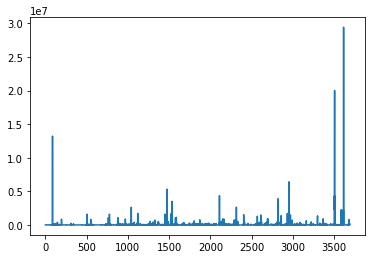

In [61]:
DF['per'].plot()

In [62]:
DF['per'].sort_values(ascending=True)

2382          1.249
2388          2.621
827           3.356
2911          4.090
2337          5.493
           ...     
3504    8603372.320
86     13214024.000
3505   13786149.021
3506   20008728.600
3615   29420846.000
Name: per, Length: 3691, dtype: float64

###### ver2

In [39]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 상가 면적 (pnu단위_19자리)
sql = '''
select sigungu_cd||bjdong_cd as pnu, sum(tot_area)
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
group by sigungu_cd||bjdong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['emd_cd','tot_sum']

# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)


# 데이터 프레임 병합
df = pd.merge(df_cremao_local_population, df_bld_rgst, on='emd_cd', how='left')

# 인구가 0명, null인 지역 제외
df = df[~df['tot_sum'].isnull()]

# 상가면적 / 거주인구
df['area_per_population'] = (df['tot_sum'] / df['l_tot'])
df = df[~(df['area_per_population']==np.inf)].reset_index(drop=True)
df = df[['emd_cd','area_per_population']]
df['base_ym'] = datetime.today().strftime("%Y%m")


### 2. DB INSERT
import datetime

table = 'm2.datadam_area_per_population'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
     # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_area_per_population;
    create table m2.datadam_area_per_population (    
    emd_cd varchar(10)
    , area_per_population double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

2022-10-30 17:21:11.771637  :  0
3692


In [2]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# 상가 면적 (pnu단위_19자리)
sql = '''
select sigungu_cd||bjdong_cd as pnu, sum(tot_area)
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
group by sigungu_cd||bjdong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['emd_cd','tot_sum']

# 거주 인구 (법정동 단위)
sql = 'select emd_cd, l_tot from m2.cremao_local_population'
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_cremao_local_population = pd.DataFrame(rows)
df_cremao_local_population.columns = ['emd_cd','l_tot']
df_cremao_local_population['emd_cd'] = df_cremao_local_population['emd_cd'] + '00'
df_cremao_local_population['l_tot']  = df_cremao_local_population['l_tot'].astype(float)

In [22]:
# 데이터 프레임 병합
df = pd.merge(df_cremao_local_population, df_bld_rgst, on='emd_cd', how='left')

# 인구가 0명, null인 지역 제외
df = df[~df['tot_sum'].isnull()]

# 상가면적 / 거주인구
df['area_per_population'] = (df['tot_sum'] / df['l_tot'])
df = df[~(df['area_per_population']==np.inf)].reset_index(drop=True)
df = df[['emd_cd','area_per_population']]
df['base_ym'] = datetime.today().strftime("%Y%m")

In [28]:
df

,emd_cd,area_per_population,base_ym
0,1111010100,27.4271,202210
1,1111010200,3.2303,202210
2,1111010300,15.5490,202210
3,1111010400,1.9947,202210
4,1111010500,4.5220,202210
...,...,...,...
5044,5013011800,1357.8367,202210
5045,5013011900,9229.5328,202210
5046,5013012000,1224.8195,202210
5047,5013012100,103.1032,202210


In [40]:
df.describe()

,area_per_population
count,3692.0000
mean,891.6574
std,11543.8463
min,0.0125
25%,17.8846
50%,65.0764
75%,215.9333
max,544453.3580


emd_nm 붙이기

In [16]:
sql = "select distinct emd_nm, emd_cd from m1.emd"
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_emd = pd.DataFrame(rows)
df_emd.columns = ['emd_nm','emd_cd']
df_emd = df_emd.drop_duplicates('emd_nm')
df_emd['emd_cd'] = df_emd['emd_cd'] + '00'

In [19]:
DF = pd.merge(df_emd, df, on='emd_cd', how='right')

In [21]:
DF[DF['emd_nm'].isnull()]

,emd_nm,emd_cd,area_per_population,base_ym
1,NaN,4150010100,31.4228,202208
3,NaN,4150010300,80.6852,202208
7,NaN,4150010700,48.1432,202208
8,NaN,4150010800,39.2711,202208
10,NaN,4150011000,29.5876,202208
...,...,...,...,...
3729,NaN,4713012600,102.9491,202208
3730,NaN,4713012700,236.5664,202208
3736,NaN,4713013300,523.2979,202208
3739,NaN,4713013600,8077.6255,202208


In [ ]:
### 2. DB INSERT
import datetime

table = 'm2.datadam_area_per_population'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
     # drop & create
    cursor.execute(
    """
    drop table if exists m2.datadam_area_per_population;
    create table m2.datadam_area_per_population (    
    emd_nm varchar(50)
    , emd_cd varchar(10)
    , calculate double precision
    , base_ym varchar(6)
    )
    distkey(emd_cd)
    compound sortkey(emd_nm, base_ym);
    commit;
    """
    )
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

###### ver3

In [ ]:
### 0. import
import psycopg2
import numpy  as np
import pandas as pd
from datetime import datetime

# display option (float 자리수)
pd.options.display.float_format = lambda x: f'{x:.4f}'


### 1. 데이터 가져오기
# AWS DW Connect
aws_conn = psycopg2.connect(
    host = 'redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
    port = 5439,
    dbname = 'dev',
    user = 'awsuser',
    password = 'cremaoAdmin1234qwer!!'
)
aws_cursor = aws_conn.cursor()

# pnu별 상가 면적
sql = '''
select sigungu_cd||bjdong_cd||case when plat_gb_cd = '1' then '2' else '1' end||bun||ji as pnu, avg(tot_area) as avg_area
  from m1.bld_rgst
 where main_purps_cd_nm not in 
    (
    select distinct main_purps_cd_nm
    from m1.bld_rgst
    where main_purps_cd_nm like '%주택%'
    )
   and base_ym = '202209'
 group by sigungu_cd||bjdong_cd||case when plat_gb_cd = '1' then '2' else '1' end||bun||ji
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_bld_rgst = pd.DataFrame(rows)
df_bld_rgst.columns = ['pnu','avg_area']
df_bld_rgst['emd_cd'] = df_bld_rgst['pnu'].str[:8] + '00'

# 거주 인구 (법정동 단위)
sql = '''
select cur_lgl_dong_cd||'00' as emd_cd , avg(case when pop_cnt = -1 then 1.5 else pop_cnt end) as pop_cnt
  from m1.kcb_stat_cm
 where bs_yr_mon = '202209'
 group by cur_lgl_dong_cd
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_kcb_stat_cm = pd.DataFrame(rows)
df_kcb_stat_cm.columns = ['emd_cd','pop_cnt']
df_kcb_stat_cm['pop_cnt'] = df_kcb_stat_cm['pop_cnt'].astype(float)


# 데이터 프레임 병합
df = pd.merge(df_bld_rgst, df_kcb_stat_cm, on='emd_cd', how='left')

# 인구가 0명, null인 지역 제외
df = df[~df['pop_cnt'].isnull()]

# 상가면적 / 거주인구
df['area_per_population'] = (df['avg_area'] / df['pop_cnt'])
df = df[~(df['area_per_population']==np.inf)].reset_index(drop=True)
df = df[['pnu','emd_cd','area_per_population']]
df['base_ym'] = datetime.today().strftime("%Y%m")

In [ ]:
### 2. DB INSERT
import datetime

table = 'm2.datadam_area_per_population'

# execute_mogrify
def execute_mogrify(conn, df, table, val):
    # Create a list of tuples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL query to execute
    cursor = conn.cursor()
    values = [cursor.mogrify(val, tup).decode('utf8') for tup in
              tuples]
    query = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)

    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    cursor.close()

# values 설정
val = '(' + ('%s,' * len(df.columns))[:-1] + ')'

# insert
for j in range(0, len(df), 10000):

    # DB Connect
    conn = psycopg2.connect(
        host='redshift-cluster-1.ctvbwnnvbdkl.ap-northeast-2.redshift.amazonaws.com',
        port=5439,
        dbname='dev',
        user='awsuser',
        password='cremaoAdmin1234qwer!!'
    )

    # 10000개 단위로 나누기
    tmp = df[j:j + 10000]

    # insert
    execute_mogrify(conn, tmp, table, val)
    print(datetime.datetime.now(), ' : ', j)
    tmp = pd.DataFrame()

# row count
print(len(df))

In [48]:
df_bld_rgst

,pnu,avg_area,emd_cd
0,1111010100100030100,187.7200,1111010100
1,1111010100100060003,260.7600,1111010100
2,1111010100100150005,388.9600,1111010100
3,1111010100100150046,46.1880,1111010100
4,1111010100100300007,136.3400,1111010100
...,...,...,...
2047183,5013032026118520000,99.3600,5013032000
2047184,5013032026118630000,132.4800,5013032000
2047185,5013032026119160000,65.9200,5013032000
2047186,5013032026119660000,99.0000,5013032000


In [49]:
df_kcb_stat_cm

,emd_cd,pop_cnt
0,1111010900,2.3
1,1111011100,2.4
2,1111011200,2.2
3,1111017300,5.7
4,1111017400,5.6
...,...,...
4979,4136011000,1.8
4980,4613014500,1.5
4981,1114017200,1.5
4982,3020014800,1.5


In [55]:
df

,pnu,emd_cd,area_per_population,base_ym
0,1111010100100030100,1111010100,81.6174,202211
1,1111010100100060003,1111010100,113.3739,202211
2,1111010100100150005,1111010100,169.1130,202211
3,1111010100100150046,1111010100,20.0817,202211
4,1111010100100300007,1111010100,59.2783,202211
...,...,...,...,...
2039585,5013032026118520000,5013032000,18.4000,202211
2039586,5013032026118630000,5013032000,24.5333,202211
2039587,5013032026119160000,5013032000,12.2074,202211
2039588,5013032026119660000,5013032000,18.3333,202211


In [ ]:
df.median()

### test

병합 대신 머지함

In [44]:
# 유동인구 테이블 기준 병합
df_f_tot[df_f_tot['emd_cd'] == (df_bld_rgst['emd_cd'][0])]

,emd_cd,f_tot
0,1111010100,5717165


In [39]:
# 법정동별 유동인구 
sql = '''
    select substring (pnu, 0, 11), sum(f_tot)
      from m2.cremao_land_floating_population
     group by substring (pnu, 0, 11)
'''
aws_cursor.execute(sql)
aws_conn.commit()
rows = aws_cursor.fetchall()

df_f_tot = pd.DataFrame(rows)
df_f_tot.columns = ['emd_cd','f_tot']

In [104]:
# 인구 대비 연면적
DF['per'] = (DF['tot_sum']/(df_cremao_local_population['l_tot'])*100)

C:\Users\duPar\AppData\Local\Temp\ipykernel_9324\4263914036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['per'] = (DF['tot_sum']/(df_cremao_local_population['l_tot'])*100)


In [108]:
DF['per'].sort_values(ascending=True)

2992    0.741
619     1.449
653     2.480
2718    4.266
4182    5.553
         ... 
18597     NaN
18598     NaN
18599     NaN
18600     NaN
18601     NaN
Name: per, Length: 17296, dtype: float64

In [103]:
df_cremao_local_population['l_tot']

0       210
1        87
2        70
3         8
4         0
       ... 
5049     72
5050     28
5051     88
5052     60
5053    417
Name: l_tot, Length: 5054, dtype: int64